In [32]:
#libraries
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from yahoo_fin.stock_info import get_data

#  Determining Cryptos for Analysis

In [116]:
#getting TODAY's date
today = datetime.strftime(datetime.today(), "%m%d%y")

In [3]:
#defining function to read data from a given url
def getdata(url):
    r = requests.get(url,headers ={'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'})
    data = pd.read_html(r.text)
    return data

In [4]:
# defining function to get top 500 cryptos by marketcap off yahoo finance
def crypto_meta_marketcap(n_count=500):
    home = 'https://finance.yahoo.com/cryptocurrencies/'
    count = 100
    n_offset = n_count//count
    
    cryptos = None
    for o in range(n_offset):
        url = f'{home}?offset={o*100}&count={count}'
        df = getdata(url)[0]
        if cryptos is None:
            cryptos = pd.DataFrame(index=range(n_count), columns=df.columns)
        # print(cryptos, cryptos.loc[o*count:(o+1)*count], df, df.values)
        # print(len(cryptos), len(df.values))
        cryptos.iloc[o*count:(o+1)*count] = df
        
    return cryptos

In [5]:
#return a df of those top 500 cryptos
c = crypto_meta_marketcap()

In [6]:
# get their date of inception by seeing when their first price entry was. Note that this is moreso the first time
# yahoo fin has data for them, but for the purposes of the analysis it doesn't matter
inception = [get_data(symbol, start_date='091714', end_date=today, index_as_date=True, interval='1wk').index[0] for symbol in c['Symbol']]
c['inception'] = inception
c[['Symbol', 'inception']]

,Symbol,inception
0,BTC-USD,2014-09-15
1,ETH-USD,2017-11-06
2,USDT-USD,2017-11-06
3,USDC-USD,2018-10-08
4,BNB-USD,2017-11-06
...,...,...
495,SERO-USD,2019-07-15
496,PHB1-USD,2021-11-01
497,KILT-USD,2021-11-22
498,HANDY-USD,2020-11-23


In [7]:
# seeing how old cryptos are in order to determine our analysis total times time (in years)
c['age'] = ((datetime.today() - c['inception']).dt.days)/365

(array([ 3.,  7.,  5., 11., 14., 19., 16., 16., 20., 24., 13., 34., 31.,
        22., 14., 10.,  7., 11.,  9., 16., 20., 11., 10.,  7., 11.,  7.,
        14.,  5., 15., 14., 81.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.]),
 array([0.02465753, 0.18460274, 0.34454795, 0.50449315, 0.66443836,
        0.82438356, 0.98432877, 1.14427397, 1.30421918, 1.46416438,
        1.62410959, 1.78405479, 1.944     , 2.10394521, 2.26389041,
        2.42383562, 2.58378082, 2.74372603, 2.90367123, 3.06361644,
        3.22356164, 3.38350685, 3.54345205, 3.70339726, 3.86334247,
        4.02328767, 4.18323288, 4.34317808, 4.50312329, 4.66306849,
        4.8230137 , 4.9829589 , 5.14290411, 5.30284932, 5.46279452,
        5.62273973, 5.78268493, 5.94263014, 6.10257534, 6.26252055,
        6.42246575, 6.58241096, 6.74235616, 6.90230137, 7.06224658,
        7.22219178, 7.38213699, 7.54208219, 7.7020274 , 7.8619726 ,
        8.02191781]),
 <BarContainer

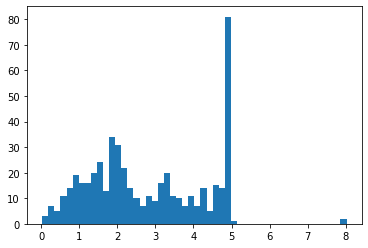

In [8]:
# plotting ages to determine decent value of total analysis time
plt.hist(c['age'].array, bins=50)

In [9]:
# From the graph we see that we can get a good amount of cryptos that are "older" than 4 years, take these
years = 4
crypstoclean = c[c['age'] > years]['Symbol'].reset_index(drop=True)

In [87]:
# make function to give you a dictionary with symbol and close prices for each crypto for the entire analysis time
# start and end date as string 'm/d/y'
# time interval as string ex: '1wk'
def analysisdata(symbols, startdate, enddate, tinterval):
    series = dict()
    for i in symbols:
        series[i] = get_data(i, start_date=startdate, end_date=enddate, index_as_date=True, interval=tinterval)['close']
    return series

In [95]:
# turn dictionary into a DataFrame
#use entire analysis time to determine which we symbols we will use
crypstocleandata = pd.DataFrame.from_dict(analysisdata(crypstoclean, '091718', today, '1wk'))

In [96]:
# array of which cryptos to drop from data (mean has to be greater than 1.01 or less than .98 over the entire time to not be considered stable coin)
drop = (crypstocleandata.mean()<.98).array + (crypstocleandata.mean()>1.01).array
crypstocleandata.head()

,BTC-USD,ETH-USD,USDT-USD,BNB-USD,XRP-USD,ADA-USD,DOGE-USD,TRX-USD,ETC-USD,LTC-USD,...,RFR-USD,AST-USD,ELA-USD,BCD-USD,MONA-USD,SBD-USD,PRE-USD,UPP-USD,AE-USD,GRS-USD
2018-09-17,6710.629883,244.330002,0.999512,10.28060,0.570689,0.089754,0.005901,0.023791,11.59860,61.366402,...,0.004136,0.083631,7.35875,2.06767,1.37821,1.025670,0.095707,0.027492,1.01913,0.578899
2018-09-24,6625.560059,232.848007,1.000360,10.01780,0.581572,0.085195,0.005906,0.022165,11.33200,61.141899,...,0.004403,0.082404,7.13009,1.94940,1.33755,1.011630,0.080757,0.026501,1.06906,0.559743
2018-10-01,6602.950195,226.119003,0.996617,10.51900,0.482039,0.084658,0.005562,0.026875,10.89810,58.160301,...,0.004507,0.094531,7.94287,1.95133,1.15220,0.983768,0.055097,0.026545,1.05868,0.550885
2018-10-08,6290.930176,195.714996,0.989570,9.49674,0.403286,0.071293,0.005158,0.023622,9.40812,52.187401,...,0.004916,0.084489,8.10389,1.70589,1.15861,1.015540,0.056346,0.028331,1.14021,0.540607
2018-10-15,6482.350098,205.141998,0.983548,9.74330,0.456694,0.075873,0.004517,0.024196,9.64013,52.915798,...,0.005640,0.095429,8.90458,1.72449,1.15259,1.001930,0.062904,0.027628,1.37744,0.544585


In [26]:
# final array with cryptos for analysis
cryptos = list(crypstocleandata.loc[:, drop ].columns)
cryptos

['BTC-USD',
 'ETH-USD',
 'BNB-USD',
 'XRP-USD',
 'ADA-USD',
 'DOGE-USD',
 'TRX-USD',
 'ETC-USD',
 'LTC-USD',
 'LINK-USD',
 'XLM-USD',
 'XMR-USD',
 'BCH-USD',
 'VET-USD',
 'FIL-USD',
 'XTZ-USD',
 'MANA-USD',
 'QNT-USD',
 'EOS-USD',
 'THETA-USD',
 'KCS-USD',
 'ZEC-USD',
 'MIOTA-USD',
 'HT-USD',
 'MKR-USD',
 'NEO-USD',
 'SNX-USD',
 'NEXO-USD',
 'ENJ-USD',
 'DASH-USD',
 'BAT-USD',
 'WAVES-USD',
 'RVN-USD',
 'ZIL-USD',
 'LRC-USD',
 'CEL-USD',
 'BTG-USD',
 'XEM-USD',
 'HOT1-USD',
 'DCR-USD',
 'XDC-USD',
 'GNO-USD',
 'QTUM-USD',
 'IOTX-USD',
 'GLM-USD',
 'FLUX-USD',
 'RPL-USD',
 'OMG-USD',
 'ZRX-USD',
 'IOST-USD',
 'ICX-USD',
 'ONT-USD',
 'STORJ-USD',
 'WAXP-USD',
 'POLY-USD',
 'VGX-USD',
 'SC-USD',
 'ZEN-USD',
 'CHSB-USD',
 'ERG-USD',
 'DGB-USD',
 'CVC-USD',
 'MED-USD',
 'EURS-USD',
 'CEEK-USD',
 'LSK-USD',
 'SYS-USD',
 'MAID-USD',
 'MVL-USD',
 'XNO-USD',
 'REN-USD',
 'ONG1-USD',
 'SNT-USD',
 'REQ-USD',
 'RLC-USD',
 'ARDR-USD',
 'POWR-USD',
 'UQC-USD',
 'DENT-USD',
 'XYO-USD',
 'NMR-USD',
 '

# Get all R matrices for Cryptos

In [136]:
# get n R matrices for our crypto symbols, input a start/end date as a string 'mdy', input epoch in integer days
# function calculates number n of matrices it will make (be careful must check it is an integer beforehand)
# initializes an empty array
# loops through starting at the original start date and gives a dictionary which we turn into a dataframe
# once a dataframe we perform some math operators and drop the first row (returns NaN values)
# then becomes R dataframe (matrix) and we append it to our array
# Does this for the entire data time and then returns the list of all the matrices
# note; here we make our R matrix have 1 day time intervals between data points 
# (not 1wk like we did above to determine symbols)
# note; yahoo fin requires at least a 1 month interval to pull data for some reason?
def rmatrices(startdate, enddate, epoch, cryptosymbols):
    n = int((datetime.strptime(enddate, '%m%d%y') - datetime.strptime(startdate, '%m%d%y')).days/epoch)
    matrices = list()
    print(n)
    for i in range(n):
        tempdict = analysisdata(cryptosymbols, datetime.strftime(datetime.strptime(startdate, '%m%d%y') + timedelta(days=(i*epoch)), '%m%d%y'), datetime.strftime(datetime.strptime(startdate, '%m%d%y') + timedelta(days=((i+1)*epoch)), '%m%d%y'), tinterval= '1d')
        tempdf = pd.DataFrame.from_dict(tempdict)
        tempdftwo = np.log(tempdf).diff()
        r = tempdftwo.drop(index=tempdftwo.index[0])
        matrices.append(r)
    return matrices

In [137]:
letsee = rmatrices('100118','101118',10, cryptos)

1


In [111]:
n = int((datetime.strptime('103118', '%m%d%y') - datetime.strptime('100118', '%m%d%y')).days/30)

In [112]:
n

1

In [138]:
letsee

[             BTC-USD   ETH-USD   BNB-USD   XRP-USD   ADA-USD  DOGE-USD  \
 2018-10-02 -0.005100 -0.015666  0.040708 -0.101471 -0.023283 -0.020058   
 2018-10-03 -0.008195 -0.029899 -0.008299  0.013966 -0.021260 -0.020820   
 2018-10-04  0.011331  0.007811 -0.001520 -0.002950  0.006354 -0.010398   
 2018-10-05  0.006938  0.023935  0.036439 -0.014499  0.020537  0.004243   
 2018-10-06 -0.005173 -0.010961 -0.025144 -0.061471 -0.020549 -0.022116   
 2018-10-07  0.002220  0.004428  0.014064 -0.012458  0.040437  0.003061   
 2018-10-08  0.007436  0.013774 -0.001179  0.015872  0.022761  0.002873   
 2018-10-09 -0.001443 -0.005568 -0.011651 -0.020409 -0.002891  0.010167   
 2018-10-10 -0.008635 -0.009754 -0.005494 -0.037086 -0.019622 -0.014839   
 2018-10-11 -0.051295 -0.175129 -0.104702 -0.188028 -0.177047 -0.104720   
 
              TRX-USD   ETC-USD   LTC-USD  LINK-USD  ...   RFR-USD   AST-USD  \
 2018-10-02  0.001858 -0.003744 -0.008384 -0.012771  ...  0.046963  0.021473   
 2018-10-03 -

In [130]:
cryptos

['BTC-USD',
 'ETH-USD',
 'BNB-USD',
 'XRP-USD',
 'ADA-USD',
 'DOGE-USD',
 'TRX-USD',
 'ETC-USD',
 'LTC-USD',
 'LINK-USD',
 'XLM-USD',
 'XMR-USD',
 'BCH-USD',
 'VET-USD',
 'FIL-USD',
 'XTZ-USD',
 'MANA-USD',
 'QNT-USD',
 'EOS-USD',
 'THETA-USD',
 'KCS-USD',
 'ZEC-USD',
 'MIOTA-USD',
 'HT-USD',
 'MKR-USD',
 'NEO-USD',
 'SNX-USD',
 'NEXO-USD',
 'ENJ-USD',
 'DASH-USD',
 'BAT-USD',
 'WAVES-USD',
 'RVN-USD',
 'ZIL-USD',
 'LRC-USD',
 'CEL-USD',
 'BTG-USD',
 'XEM-USD',
 'HOT1-USD',
 'DCR-USD',
 'XDC-USD',
 'GNO-USD',
 'QTUM-USD',
 'IOTX-USD',
 'GLM-USD',
 'FLUX-USD',
 'RPL-USD',
 'OMG-USD',
 'ZRX-USD',
 'IOST-USD',
 'ICX-USD',
 'ONT-USD',
 'STORJ-USD',
 'WAXP-USD',
 'POLY-USD',
 'VGX-USD',
 'SC-USD',
 'ZEN-USD',
 'CHSB-USD',
 'ERG-USD',
 'DGB-USD',
 'CVC-USD',
 'MED-USD',
 'EURS-USD',
 'CEEK-USD',
 'LSK-USD',
 'SYS-USD',
 'MAID-USD',
 'MVL-USD',
 'XNO-USD',
 'REN-USD',
 'ONG1-USD',
 'SNT-USD',
 'REQ-USD',
 'RLC-USD',
 'ARDR-USD',
 'POWR-USD',
 'UQC-USD',
 'DENT-USD',
 'XYO-USD',
 'NMR-USD',
 '